# Predicting Ground Motion Equation using Artificial Neural Networks

This command installs the necessary Python libraries:

1. Tensorflow: Used for building and training the Artificial Neural Network (ANN).

2. Pandas: Used for loading, processing, and manipulating structured data (CSV files).

3. Numpy: Provides numerical operations and array handling.

4. Matplotlib: Used for visualizing data and model performance.

5. Scikit-learn: Provides tools for preprocessing data, splitting datasets, and evaluating models.

In [ ]:
# Install required libraries (if not already installed)
!pip install tensorflow pandas numpy matplotlib scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

1. **Load the Data**: The CSV file is read using pd.read_csv() with specific arguments to skip the first 8 rows (which are assumed to be descriptions or metadata). The columns "Stream" and "Time" are treated as strings, while the "Vertical", "Horizontal 1", and "Horizontal 2" columns are treated as floats.

2. **Rename Columns**: The columns "Horizontal 1" and "Horizontal 2" are renamed to "Horizontal_1" and "Horizontal_2" to standardize the column names.

3. **Drop Missing Values**: Any rows with missing data are dropped using df.dropna() to ensure clean data for model training.

In [ ]:
# Load and Clean CSV File
file_path = "/content/btp_data.csv"

In [ ]:
def clean_csv(file_path):
    df = pd.read_csv(file_path, skiprows=8, dtype={"Stream": str, "Time": str, "Vertical": float,
                                       "Horizontal 1": float, "Horizontal 2": float})

    # Rename headers
    df = df.rename(columns={"Horizontal 1": "Horizontal_1", "Horizontal 2": "Horizontal_2"})

    # Drop rows with missing values
    df = df.dropna()

    return df

In [ ]:
df = clean_csv(file_path)

In [ ]:
df.head(5)

,Stream,Time,Vertical,Horizontal_1,Horizontal_2
0,NZ_HWHS_21_HN,2024-11-01T18:46:16.105,-0.000006,0.000028,-0.000119
1,NZ_HWHS_21_HN,2024-11-01T18:46:16.110,-0.000021,0.000013,-0.000185
2,NZ_HWHS_21_HN,2024-11-01T18:46:16.115,-0.000119,-0.000173,0.000078
3,NZ_HWHS_21_HN,2024-11-01T18:46:16.120,-0.000220,-0.000310,0.000121
4,NZ_HWHS_21_HN,2024-11-01T18:46:16.125,-0.000148,-0.000137,-0.000085


**PGA (Peak Ground Acceleration)** : This takes the absolute values of the "Vertical," "Horizontal_1," and "Horizontal_2" columns for each row and finds the maximum among them.

**PGV (Peak Ground Velocity)**: This calculates the absolute difference between consecutive rows (time steps) for each column and then finds the maximum value across "Vertical," "Horizontal_1," and "Horizontal_2"

In [ ]:
# Compute PGA & PGV (Assuming they are the max absolute values)
df['PGA'] = df[['Vertical', 'Horizontal_1', 'Horizontal_2']].abs().max(axis=1)
df['PGV'] = df[['Vertical', 'Horizontal_1', 'Horizontal_2']].diff().abs().max(axis=1)

In [ ]:
# Drop NaN values from PGV calculation
df = df.dropna()

**Feature Selection**: Only Vertical is used as input (X).

**Target Variables**:

1. y_pga → Predicting Peak Ground Acceleration (PGA).

2. y_pgv → Predicting Peak Ground Velocity (PGV).

We aim to build two separate models, one for each target.

In [ ]:
# Define Features & Target Variables
X = df[['Vertical']]  # Only 'Vertical' as input
y_pga = df[['PGA']]  # Target: PGA
y_pgv = df[['PGV']]  # Target: PGV

In [ ]:
df.head(5)

,Stream,Time,Vertical,Horizontal_1,Horizontal_2,PGA,PGV
1,NZ_HWHS_21_HN,2024-11-01T18:46:16.110,-0.000021,0.000013,-1.846890e-04,0.000185,0.000066
2,NZ_HWHS_21_HN,2024-11-01T18:46:16.115,-0.000119,-0.000173,7.850000e-05,0.000173,0.000263
3,NZ_HWHS_21_HN,2024-11-01T18:46:16.120,-0.000220,-0.000310,1.208320e-04,0.000310,0.000137
4,NZ_HWHS_21_HN,2024-11-01T18:46:16.125,-0.000148,-0.000137,-8.500000e-05,0.000148,0.000206
5,NZ_HWHS_21_HN,2024-11-01T18:46:16.130,-0.000177,0.000094,2.530000e-07,0.000177,0.000231


Splitting Data:

1. X_train, X_test: Training and testing sets for input (Vertical).

2. y_train_pga, y_test_pga: Training and testing sets for PGA.

3. y_train_pgv, y_test_pgv: Training and testing sets for PGV.

Why _ in second split:
Since X_train and X_test remain the same for both models, _ avoids redundancy.

Test Size: 20% of the data is used for testing.

Random Seed: Ensures reproducibility.

In [ ]:
# Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train_pga, y_test_pga = train_test_split(X, y_pga, test_size=0.2, random_state=42)
_, _, y_train_pgv, y_test_pgv = train_test_split(X, y_pgv, test_size=0.2, random_state=42)

In [ ]:
# Normalize the Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Save the Scaler for Future Use
np.save('/content/scaler_mean.npy', scaler.mean_)
np.save('/content/scaler_var.npy', scaler.var_)

Function **build_ann()**: Creates an Artificial Neural Network (ANN) model.

**Layers**:

1. Input Layer: Takes one feature (Vertical).

2. Hidden Layers: 64 neurons (ReLU activation), 32 neurons (ReLU activation), 16 neurons (ReLU activation)

3. Output Layer: 1 neuron (predicts PGA or PGV).

**Optimizer**: Adam (adaptive learning rate).

**Metric**: Mean Absolute Error (mae) to evaluate prediction accuracy.

In [ ]:
# Define ANN Model Function
def build_ann():
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(1,)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(1)  # Output Layer (Single Prediction)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [ ]:
# Train Model for PGA Prediction
model_pga = build_ann()
history_pga = model_pga.fit(X_train_scaled, y_train_pga, epochs=50, batch_size=8, validation_data=(X_test_scaled, y_test_pga))
model_pga.save("/content/pga_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 6.4636e-05 - mae: 0.0023 - val_loss: 4.1566e-07 - val_mae: 4.3510e-04
Epoch 2/50
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 3.1626e-06 - mae: 6.1802e-04 - val_loss: 1.2456e-07 - val_mae: 1.7406e-04
Epoch 3/50
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1.2722e-07 - mae: 2.2969e-04 - val_loss: 1.0421e-07 - val_mae: 1.9355e-04
Epoch 4/50
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 1.3689e-07 - mae: 2.4194e-04 - val_loss: 1.5948e-07 - val_mae: 2.4167e-04
Epoch 5/50
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1.2897e-07 - mae: 2.3442e-04 - val_loss: 1.0153e-07 - val_mae: 1.8906e-04
Epoch 6/50
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 1.3493e-07 - mae: 2.4012e-04 - val_loss: 1.1618e-07 - val_mae: 1.5913e-04
Epoch 7/50
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 1.3150e-07 - mae: 2.3895e-04 - val_loss: 1.2581e-07 - val_mae: 1.6907e-04
Epoch 8/50
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 11s

In [ ]:
# Train Model for PGV Prediction
model_pgv = build_ann()
history_pgv = model_pgv.fit(X_train_scaled, y_train_pgv, epochs=50, batch_size=8, validation_data=(X_test_scaled, y_test_pgv))
model_pgv.save("/content/pgv_model.h5")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3600/3600 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.1470e-04 - mae: 0.0026 - val_loss: 2.8012e-08 - val_mae: 1.2825e-04
Epoch 2/50
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 8.9218e-08 - mae: 1.5663e-04 - val_loss: 2.5401e-08 - val_mae: 1.0487e-04
Epoch 3/50
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 7.3280e-07 - mae: 3.0708e-04 - val_loss: 2.3177e-08 - val_mae: 1.1567e-04
Epoch 4/50
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 2.9098e-08 - mae: 1.1184e-04 - val_loss: 3.3453e-08 - val_mae: 1.1908e-04
Epoch 5/50
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.7558e-07 - mae: 1.7422e-04 - val_loss: 1.0977e-08 - val_mae: 7.5698e-05
Epoch 6/50
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 1.8791e-08 - mae: 1.0607e-04 - val_loss: 1.7974e-08 - val_mae: 1.0386e-04
Epoch 7/50
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1.6433e-08 - mae: 9.9021e-05 - val_loss: 2.8320e-08 - val_mae: 1.5135e-04
Epoch 8/50
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step -

In [ ]:
# Predictions
y_pred_pga = model_pga.predict(X_test_scaled)
y_pred_pgv = model_pgv.predict(X_test_scaled)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
# Evaluate Models
mae_pga = mean_absolute_error(y_test_pga, y_pred_pga)
mse_pga = mean_squared_error(y_test_pga, y_pred_pga)
r2_pga = r2_score(y_test_pga, y_pred_pga)

mae_pgv = mean_absolute_error(y_test_pgv, y_pred_pgv)
mse_pgv = mean_squared_error(y_test_pgv, y_pred_pgv)
r2_pgv = r2_score(y_test_pgv, y_pred_pgv)

print("PGA Model Evaluation:")
print(f"MAE  = {mae_pga:.4f}, R² Score = {r2_pga:.4f}")

print("PGV Model Evaluation:")
print(f"MAE  = {mae_pgv:.4f}, R² Score = {r2_pgv:.4f}")

PGA Model Evaluation:
MAE  = 0.0003, R² Score = 0.2633
PGV Model Evaluation:
MAE  = 0.0001, R² Score = -0.1457


**Purpose**: Visualizes how well the model predicts PGA.

plt.figure(figsize=(10, 4)): Sets figure size.

plt.subplot(1, 2, 1): Creates a subplot (1 row, 2 columns, 1st plot).

Scatter Plot (sns.scatterplot): X-axis: Actual PGA values, Y-axis: Predicted PGA values, Color: Blue, with transparency

Text(0.5, 1.0, 'Actual vs Predicted PGA')

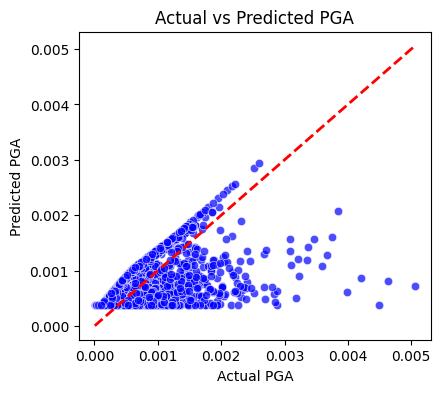

In [ ]:
import seaborn as sns

# Plot Actual vs. Predicted for PGA
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_pga.values.flatten(), y=y_pred_pga.flatten(), color="blue", alpha=0.7)
plt.plot([y_test_pga.min(), y_test_pga.max()], [y_test_pga.min(), y_test_pga.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual PGA")
plt.ylabel("Predicted PGA")
plt.title("Actual vs Predicted PGA")

**Purpose**: Evaluates model accuracy for PGV predictions by comparing actual vs. predicted values.

plt.subplot(1, 2, 2): Adds the second subplot (side-by-side with the PGA plot).

Scatter Plot (sns.scatterplot): X-axis: Actual PGV values, Y-axis: Predicted PGV values, Color: Green, with transparency

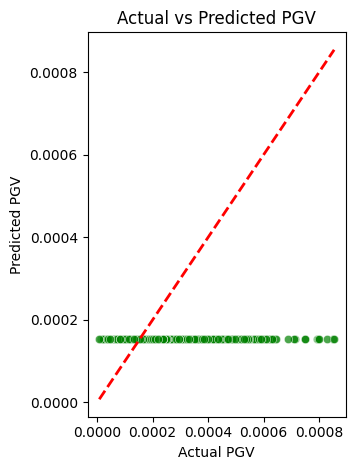

In [ ]:
# Plot Actual vs. Predicted for PGV
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_pgv.values.flatten(), y=y_pred_pgv.flatten(), color="green", alpha=0.7)
plt.plot([y_test_pgv.min(), y_test_pgv.max()], [y_test_pgv.min(), y_test_pgv.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual PGV")
plt.ylabel("Predicted PGV")
plt.title("Actual vs Predicted PGV")

plt.tight_layout()
plt.show()

**Purpose**: Visualizes training & validation loss curves for both PGA & PGV models to check convergence and overfitting.

Plotting Loss Curves:

1. PGA Training Loss: Blue solid line.

2. PGA Validation Loss: Red dashed line.

3. PGV Training Loss: Green solid line.

4. PGV Validation Loss: Orange dashed line.

X-axis (Epochs): Represents the number of training iterations.

Y-axis (Loss (MSE)): Tracks how well the model is learning.

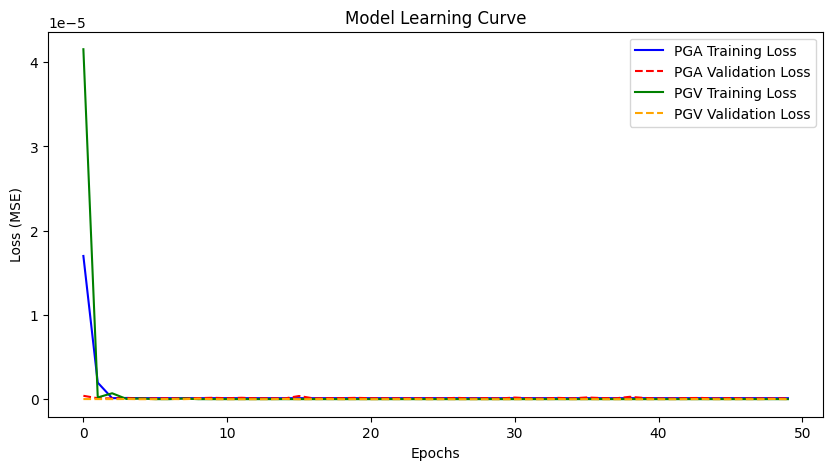

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_pga.history['loss'], label="PGA Training Loss", color="blue")
plt.plot(history_pga.history['val_loss'], label="PGA Validation Loss", color="red", linestyle="--")
plt.plot(history_pgv.history['loss'], label="PGV Training Loss", color="green")
plt.plot(history_pgv.history['val_loss'], label="PGV Validation Loss", color="orange", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Model Learning Curve")
plt.legend()
plt.show()

**Purpose**: Visualizes residuals (errors) for PGA & PGV predictions to analyze model accuracy and bias.

**Residual Calculation**:

1. residuals_pga = y_test_pga - y_pred_pga (Difference between actual & predicted PGA values).

2. residuals_pgv = y_test_pgv - y_pred_pgv (Difference between actual & predicted PGV values).

Plots PGA residuals as a histogram with KDE (Kernel Density Estimate) for smooth distribution.

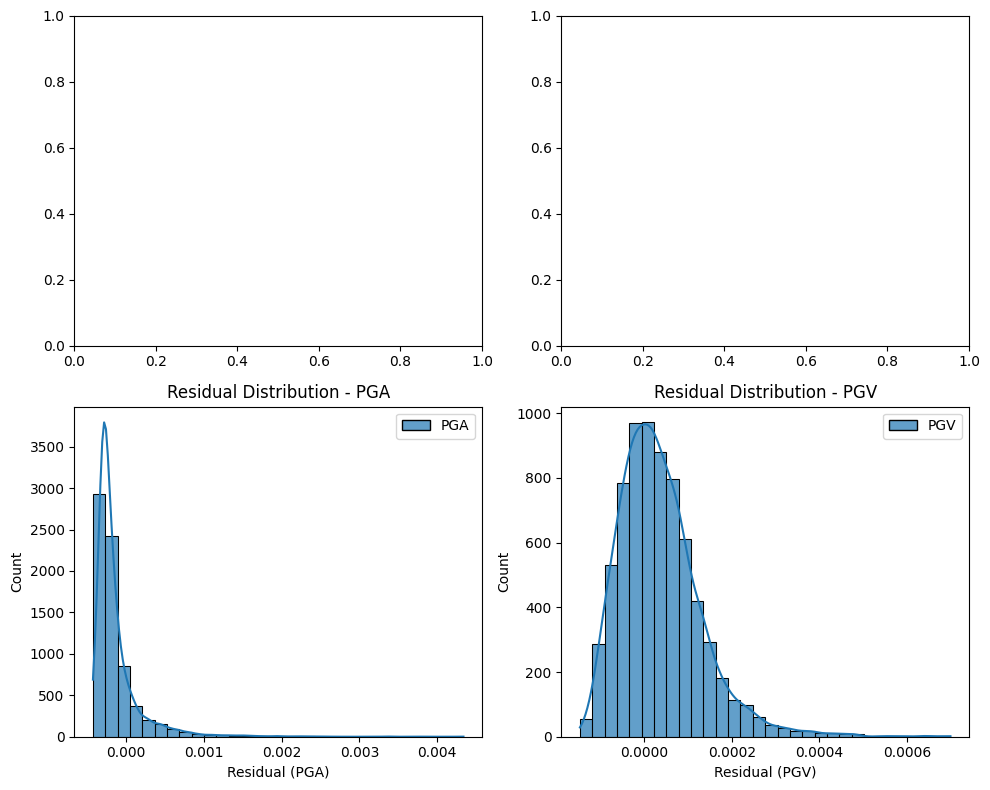

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

residuals_pga = y_test_pga - y_pred_pga
residuals_pgv = y_test_pgv - y_pred_pgv

# Create a figure and axes using plt.subplots()
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns of subplots

# Now you can use axes[row_index, col_index] to access individual subplots
sns.histplot(residuals_pga, bins=30, kde=True, color="blue", ax=axes[1, 0], alpha=0.7)
sns.histplot(residuals_pgv, bins=30, kde=True, color="green", ax=axes[1, 1], alpha=0.7)
axes[1, 0].set_xlabel("Residual (PGA)")
axes[1, 1].set_xlabel("Residual (PGV)")
axes[1, 0].set_title("Residual Distribution - PGA")
axes[1, 1].set_title("Residual Distribution - PGV")

plt.tight_layout()
plt.show()

In [37]:
# Example input
vertical_input = np.array([[-0.000015]])
vertical_scaled = scaler.transform(vertical_input)
predicted_pga = model_pga.predict(vertical_scaled)
predicted_pgv = model_pgv.predict(vertical_scaled)

print(f"Predicted PGA: {predicted_pga[0][0]}")
print(f"Predicted PGV: {predicted_pgv[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted PGA: 0.0003786738670896739
Predicted PGV: 0.00015443036681972444


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
